In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from benchmarks.runs.exploring_utils import RunAnalyser, adaptive_filter, non_adaptive_filter, model_filter
import re

In [20]:
run_path = '../'
test_name = 'Wave_halton'
test_path = os.path.join(run_path, test_name)

In [3]:
runs = sorted([m for m in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, m))])
analyser = RunAnalyser(runs, test_path)

<Figure size 700x700 with 0 Axes>

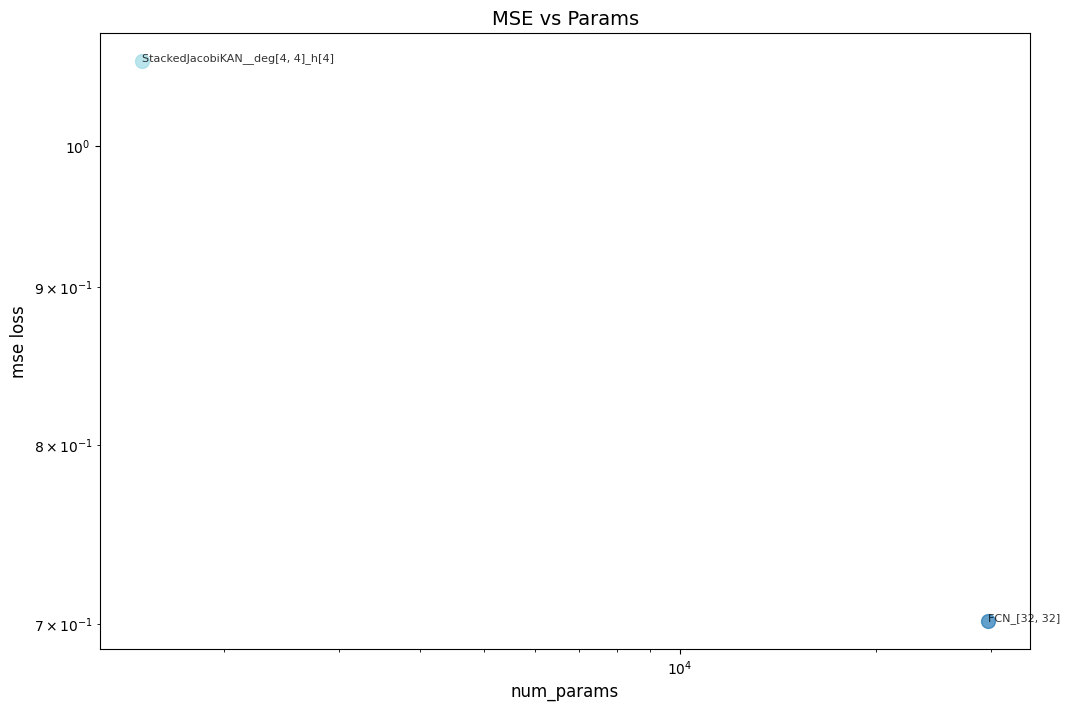

In [4]:
analyser.plot_mse_over_params()

<Figure size 700x700 with 0 Axes>

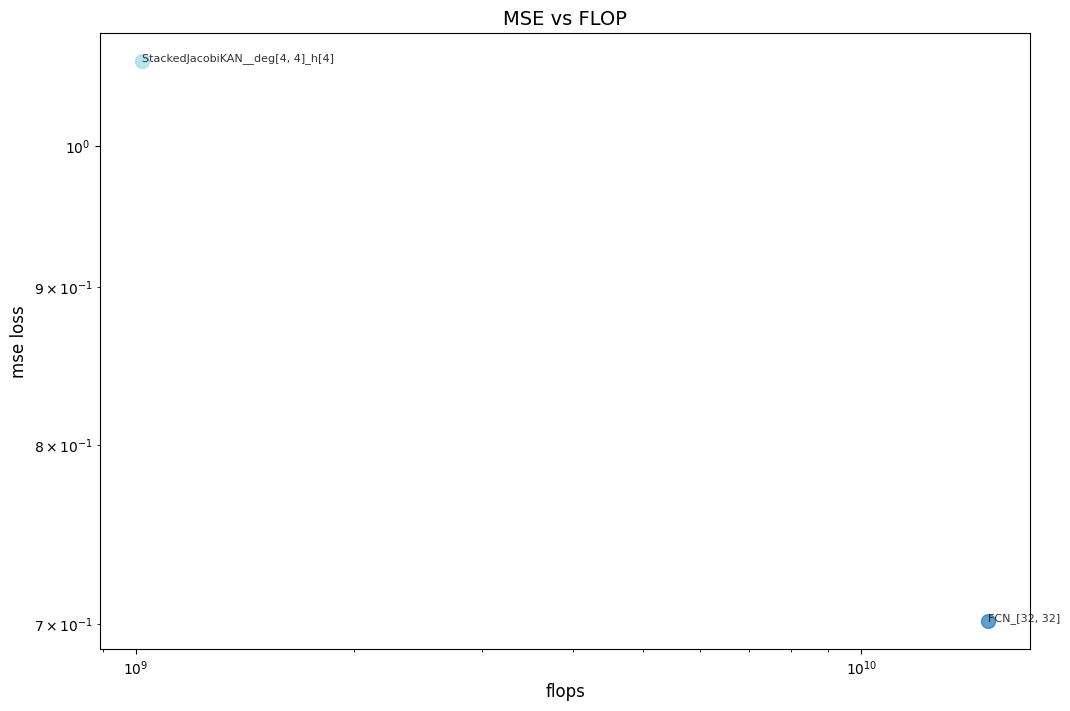

In [5]:
analyser.plot_mse_over_flops()

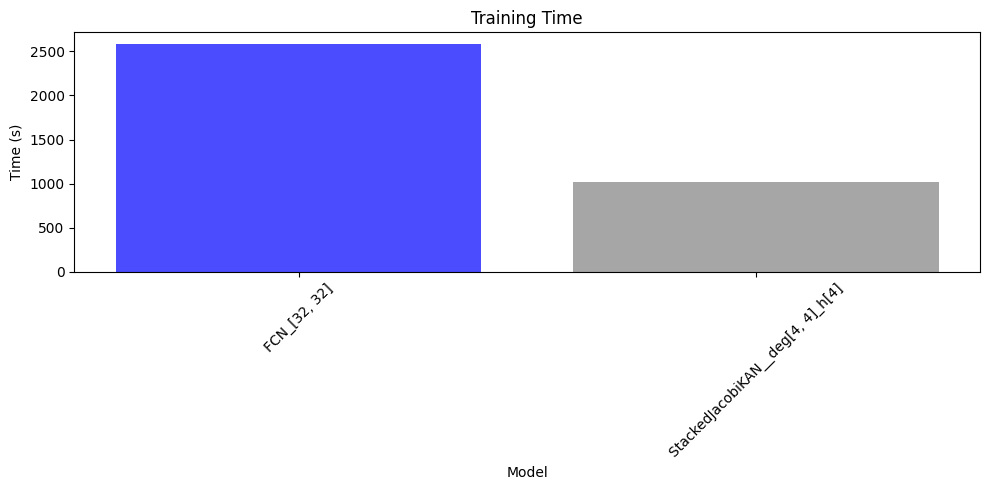

In [6]:
analyser.plot_training_times(filter=lambda x: 'Stacked' in x or 'FCN' in x)

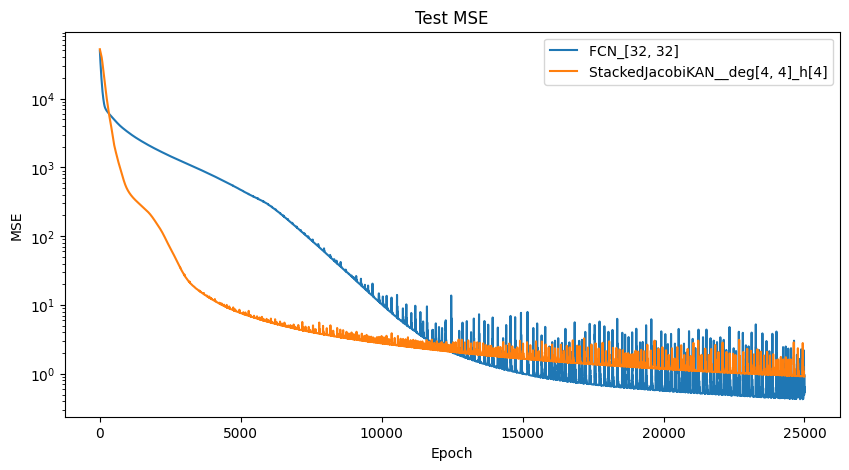

In [7]:
analyser.plot_mses()

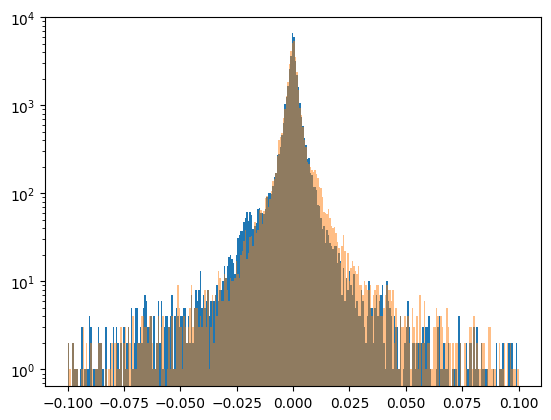

In [8]:
with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/{test_name}/StackedJacobiKAN__deg[4, 4]_h[4]/test_25000.npy', 'rb') as f:
    pred_jkan = np.load(f).reshape(200, 200, -1)
with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/{test_name}/FCN_[32, 32]/test_25000.npy', 'rb') as f:
    pred_fcn = np.load(f).reshape(200, 200, -1)
with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/{test_name}/StackedJacobiKAN__deg[4, 4]_h[4]/test_exact.npy', 'rb') as f:
    exact = np.load(f).reshape(200, 200, -1)

exact.shape, pred_jkan.shape, pred_fcn.shape

rae = lambda exact, pred: (np.abs(exact - pred) / (np.abs(exact)))

slice=0

rE = lambda exact, pred: ((exact - pred) / (np.abs(exact)))
re_fcn = rE(exact[1:199, 1:199, slice], pred_fcn[1:199, 1:199, slice])
re_jkan = rE(exact[1:199, 1:199, slice], pred_jkan[1:199, 1:199, slice])
plt.hist(re_fcn.flatten(), bins=300, label='FCN', range=(-0.1, 0.1))
plt.hist(re_jkan.flatten(), bins=300, label='Jacobi KAN', alpha=0.5, range=(-0.1, 0.1))
plt.yscale('log')

/tmp/ipykernel_1773691/729268031.py:10: RuntimeWarning: invalid value encountered in divide
  rae = lambda exact, pred: (np.abs(exact - pred) / (np.abs(exact)))


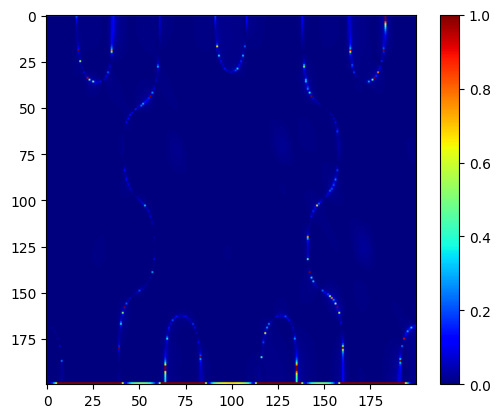

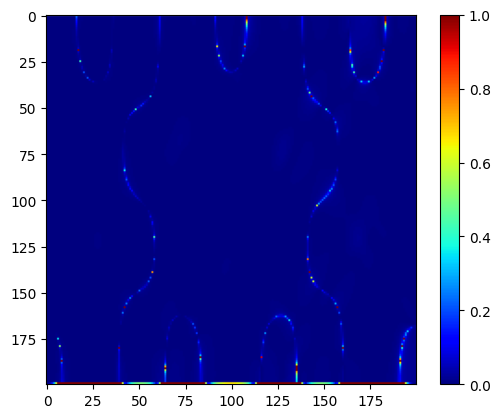

In [9]:
plt.imshow(rae(exact, pred_jkan), cmap='jet', vmax=1)
plt.colorbar()
plt.show()
plt.imshow(rae(exact, pred_fcn), cmap='jet', vmax=1)
plt.colorbar()
plt.show()

In [16]:
from collections import defaultdict
rae = lambda exact, pred: (np.abs(exact - pred) / (np.abs(exact)))

decomps = ['grid', 'uniform', 'sobol', 'halton']
times = {
    d: {
        a: None for a in analyser.runs
        }
    for d in decomps
    }
mses = defaultdict(list)
for n, d in enumerate(decomps):
    # plt.subplot(3, 3, n+1)
    test_name = f'Wave_{d}'
    test_path = os.path.join(run_path, test_name)
    runs = sorted([m for m in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, m))])
    analyser = RunAnalyser(runs, test_path)
    m = analyser.get_mses()
    for k, v in m.items():
        mses[k].append((d, v))

In [17]:
mses

defaultdict(list,
            {'FCN_[32, 32]': [('grid',
               array([4.94009180e+04, 4.82964805e+04, 4.72432227e+04, ...,
                      3.56685966e-01, 3.59275132e-01, 3.63157213e-01])),
              ('uniform',
               array([4.95142852e+04, 4.84138789e+04, 4.73640898e+04, ...,
                      4.26758289e-01, 4.27975923e-01, 4.23796177e-01])),
              ('sobol',
               array([4.96553633e+04, 4.85476602e+04, 4.74909531e+04, ...,
                      4.18144137e-01, 4.26009178e-01, 4.30387676e-01])),
              ('halton',
               array([4.96540273e+04, 4.85463906e+04, 4.74898047e+04, ...,
                      5.26893675e-01, 5.58857381e-01, 6.40473485e-01]))],
             'StackedJacobiKAN__deg[4, 4]_h[4]': [('grid',
               array([5.18505898e+04, 5.16426172e+04, 5.14374375e+04, ...,
                      1.01522422e+00, 1.31504393e+00, 1.53042400e+00])),
              ('uniform',
               array([5.19229023e+04, 5.17

grid
grid
grid
grid
[('n=grid', 0.0), ('n=uniform', 0.03548896816778321), ('n=sobol', 0.11938526746868217), ('n=halton', 0.14112928043594436)]
grid
grid
grid
grid
[('n=grid', 0.0), ('n=uniform', 0.07769170624971729), ('n=sobol', 0.021546465456557345), ('n=halton', 0.0529112300835839)]


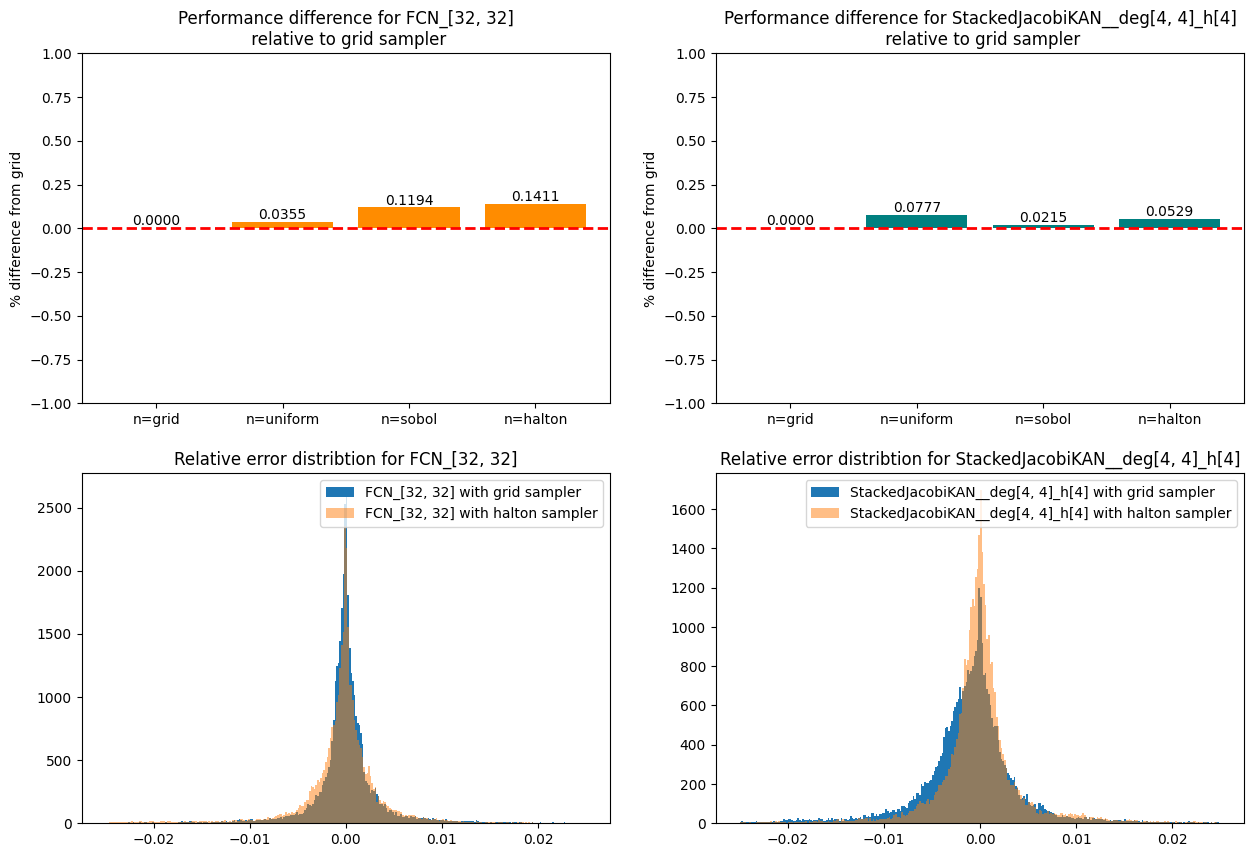

In [28]:
plt.figure(figsize=(15, 10))
cs = {
    'FCN_[32, 32]': 'darkorange',
    'StackedJacobiKAN__deg[4, 4]_h[4]': 'teal'
}
z = 20000
for n, (k, v) in enumerate(mses.items()):
    
    ns_bar = []
    ys_bar = []
    for nn, ms in v:
        ns_bar.append(f'n={nn}')
        ys_bar.append((np.mean(ms[z:]) - np.mean(mses[k][0][1][z:])) / np.mean(mses[k][0][1][z:]))
        print(mses[k][0][0])
    print(list(zip(ns_bar, ys_bar)))

    ax = plt.subplot(2, 2, n+1)
    bars = plt.bar(ns_bar, ys_bar, color=cs[k])
    plt.ylim((-1, 1))
    ax.bar_label(bars, fmt='%.4f')
    plt.ylabel('% difference from grid')
    plt.title(f'Performance difference for {k}\n relative to grid sampler')

    plt.axhline(y=0,linewidth=2, color='red', ls='--')

    plt.subplot(2, 2, n+1+2)

    with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave_halton/{k}/test_25000.npy', 'rb') as f:
        pred_halton = np.load(f).reshape(200, 200, -1)
    with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave_grid/{k}/test_25000.npy', 'rb') as f:
        pred_grid = np.load(f).reshape(200, 200, -1)
    with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave_halton/StackedJacobiKAN__deg[4, 4]_h[4]/test_exact.npy', 'rb') as f:
        exact = np.load(f).reshape(200, 200, -1)

    rae = lambda exact, pred: (np.abs(exact - pred) / (np.abs(exact)))

    slice=0

    rE = lambda exact, pred: ((exact - pred) / (np.abs(exact)))
    re_grid = rE(exact[1:199, 1:199, slice], pred_grid[1:199, 1:199, slice])
    re_halton = rE(exact[1:199, 1:199, slice], pred_halton[1:199, 1:199, slice])
    plt.hist(re_grid.flatten(), bins=300, label=f'{k} with grid sampler', range=(-0.025, 0.025))
    plt.hist(re_halton.flatten(), bins=300, label=f'{k} with halton sampler', alpha=0.5, range=(-0.025, 0.025))
    plt.title(f'Relative error distribtion for {k}')
    plt.legend()

    # for n, ms in v:
    #     plt.plot(ms, label=f"{n}")
    # plt.legend()
    # plt.title(f'Varying dataset size for {k}')
    # plt.yscale('log')
    # plt.ylabel('log MSE')
    # plt.xlabel('iterations')

plt.show()

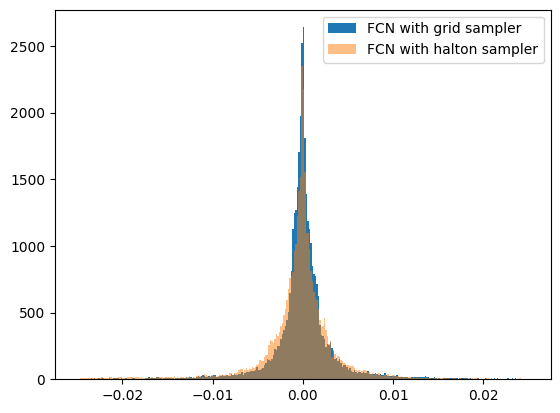

In [26]:
with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave_halton/FCN_[32, 32]/test_25000.npy', 'rb') as f:
    pred_halton = np.load(f).reshape(200, 200, -1)
with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave_grid/FCN_[32, 32]/test_25000.npy', 'rb') as f:
    pred_grid = np.load(f).reshape(200, 200, -1)
with open(f'/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave_halton/StackedJacobiKAN__deg[4, 4]_h[4]/test_exact.npy', 'rb') as f:
    exact = np.load(f).reshape(200, 200, -1)

rae = lambda exact, pred: (np.abs(exact - pred) / (np.abs(exact)))

slice=0

rE = lambda exact, pred: ((exact - pred) / (np.abs(exact)))
re_grid = rE(exact[1:199, 1:199, slice], pred_grid[1:199, 1:199, slice])
re_halton = rE(exact[1:199, 1:199, slice], pred_halton[1:199, 1:199, slice])
plt.hist(re_grid.flatten(), bins=300, label='FCN with grid sampler', range=(-0.025, 0.025))
plt.hist(re_halton.flatten(), bins=300, label='FCN with halton sampler', alpha=0.5, range=(-0.025, 0.025))
plt.legend()
# plt.yscale('log')

In [29]:
mses

defaultdict(list,
            {'FCN_[32, 32]': [('grid',
               array([4.94009180e+04, 4.82964805e+04, 4.72432227e+04, ...,
                      3.56685966e-01, 3.59275132e-01, 3.63157213e-01])),
              ('uniform',
               array([4.95142852e+04, 4.84138789e+04, 4.73640898e+04, ...,
                      4.26758289e-01, 4.27975923e-01, 4.23796177e-01])),
              ('sobol',
               array([4.96553633e+04, 4.85476602e+04, 4.74909531e+04, ...,
                      4.18144137e-01, 4.26009178e-01, 4.30387676e-01])),
              ('halton',
               array([4.96540273e+04, 4.85463906e+04, 4.74898047e+04, ...,
                      5.26893675e-01, 5.58857381e-01, 6.40473485e-01]))],
             'StackedJacobiKAN__deg[4, 4]_h[4]': [('grid',
               array([5.18505898e+04, 5.16426172e+04, 5.14374375e+04, ...,
                      1.01522422e+00, 1.31504393e+00, 1.53042400e+00])),
              ('uniform',
               array([5.19229023e+04, 5.17

In [45]:
xx = mses['FCN_[32, 32]'][0][1][24000:]
np.mean(xx), np.std(xx)

(0.5949236479699611, 0.4772840070084947)

In [46]:
xy = mses['FCN_[32, 32]'][-1][1][24000:]
np.mean(xy)

0.6955736333727837

In [47]:
(np.mean(xy) - np.mean(xx))/(np.std(xx)/np.sqrt(1000))

6.668633259483056